# 7 job search 3: search with learning

In [21]:
!pip install interpolation # a new library we are going to use.

In [22]:
# njit (just-in-time), prange, vectorize (?)

from numba import njit, prange, vectorize

# mlinterp, interp (?)
from interpolation import mlinterp, interp

# a new library: math (?); gamma (?)
from math import gamma

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm # cm (?)

# 0 Illustrations for libraries and functions

## 0.1 prange
to specify that a loop can be parallelized
(Need to ensure that the loop does not have cross iteration dependencies except for supported reductions.)

## 0.2 vectorize()
It allows Python functions taking scalar input argument to be used as NumPy ufuncs.
Creating a traditional NumPy ufunc involves writing some C code.
Using the vectorize(), Numba compile a pure Python function into a ufunc that operates over NumPy arrays fast as in C.

With it, you write your function as operating over input scalars, rather than arrays. Numba will generate the surrounding loop allowing efficient iteration over the actual inputs.

## 0.3 mlinterp(=multilinear interpolation?)


## 0.4 interp (?)
One-dimensional linear interpolation.
It will return the one-dimensional piecewise linear interpolant to a function with given discrete data points $(xp, fp)$, evaluated at $x$.

## 0.5 math
This module provides access to the [(mathematical function)](https://docs.python.org/3/library/math.html) defined by C standard. 

## 0.6 math.gamma(x)
return the Gamma function at $x$.

Remark:
The gamma funcition is defined for all complex numbers except the non-positive integers.
### Def
For any positive integer $n$, $$\Gamma (n) = (n-1)! $$.

If the real part of the complex number $z$ is positive ($\mathcal{R} (Z) >0$), then the integral $$\Gamma (z) \int^{\infty}_{0} x^{z-1} e^{-x}dx  \tag{1} $$


## 0.7 matplotlib.cm (=colormap)
This module provides a large set of colormaps, functions for registering new colormaps and for getting a colormap by name, and a mixin class for adding color mapping functionality.

# 1 Overview

We will consider an extension of the McCall job search model.

(PS. John told me that it is a Bayesian learning process.).

## 1.1 Setting ups in the McCall model

An unemployed worker decides when to accept a permanent position at a specified wage, given

1. his or her discount factor $\beta$;
2. the level of unemployment comensation $c$;
3. the distribution from which wage offers are drawn $\psi$.

## 1.2 New setting in the Extended model

The wage distribution is unknown and must be learned (?how to learn? Reference: Sargent, Recursive Macroeconomics.)

## 1.3 Model features

1. Infinite horizon dynamic programming with two states and one binary control.
2. Bayesian updating to learn with the unknown distribution.

How to understand?:

1. Infinite horizon dynamic programming
2. Two states
3. One binary control
4. Bayesian learning.
5. Bayesian updating.

# 2 Model

## 2.1 The basic McCall Model

An unemployed worker is presented in each period with a permant job offer at wage $W_t$.

At time $t$, the worker can either

1. Accept the offer and work **permanently** at constant wage $W_t$; or 
2. Reject the offer, receive unemployment compensation $c$ and reconsider another offer next period.

The wage sequence $\{ W_t \}$ is iid and generated from known density $q$ (a distribution).

The worker aims to maximize the expected discounted sum of earnings $\mathbb{E} \sum^{\infty}_{t=0} \beta^t y_t$. The function $V$ satisfies the recursion
$$
v(w) = \max \{ \frac{w}{1- \beta}, c+ \beta \int v(w') q(w')dw' \} \tag{2}
$$
The optimal policy has the form $\mathbb{1}\{ w \geq \bar w \}$, where $\bar w$ is a constant, called the reservation wage.

## 2.2 Offer distribution unknown



The new model is the same as above except for the fact that

1. the density $q$ is unknown;
2. the worker learns about $q$ by starting with a prior and updating based on wage offers that she observes.

The worker knows there are two possible distributions $F$ and $G$ with densities $f$ and $g$.

At the start of time, "nature" selects $q$ to be either $f$ or $g$--the wage distribution from which the entire sequence $\{W_t\}$ will be drawn.

This choice is not observed by the worker, who puts **prior probability** $\pi_0$ on $f$ being chosen or puts prior probability $1- \pi_0$ on $g$ being chosen.

### Update rule

Worker's time $t$ estimate of the distribution is $\pi_t f + (1- \pi_t) g$, where $\pi_t$ updates via
$$
\pi_{t+1} = \frac{\pi_t f(w_{t+1})}{\pi_t f(w_{t+1}) + (1- \pi_t) g(w_{t+1})} \tag{3}
$$
which follows from Bayes' rule and tells us:
$$
\mathbb{P} \{ q=f | W = w \} = \frac{\mathbb P \{W=w|q=f\} \mathbb{P} \{ q=f\} }{ \mathbb P \{ W=w \} } \tag{4}
$$
where the denominator is:
$$
\mathbb P \{ W=w \}= \sum_{\omega \in \{ f,g \}} \mathbb P \{ W = w | q = \omega \} \mathbb P\{ q = \omega \} \tag{5}
$$
The fact that [(3)](#) is recursive allows us to progress to a recursive solution method.

Let 
$$
q_{\pi} (w) = \pi f(w) + (1- \pi) g(w) \tag{6}
$$
and
$$
\kappa (w , \pi) = \frac{\pi f(w) }{\pi f(w) + (1- \pi) g(w)} \tag{7}
$$
(**I have question about the subscripts here**)

we can express the value function for the unemployed worker recursively as:
$$
v(w, \pi) = \max \{ \frac{w}{1- \beta}, c + \beta \int v(w', \pi') q_{\pi} (w')dw' \} \tag{8}
$$
where 
$$
\pi' = \kappa (w', \pi) \tag{9}
$$
(**I have a question here as well: so [(9)](#) means that future $\pi$ depends on current $\pi'$?**)

#### Remark

1. Here, we should refer to the 'Choice under uncertainty' in Micro and 6.6 in Sargent's Recursive Macroeconomics;
2. The current guess $\pi$ is a state variable, since it affects the worker's perception of probabilities for future rewards.

## 2.3 Parameterization

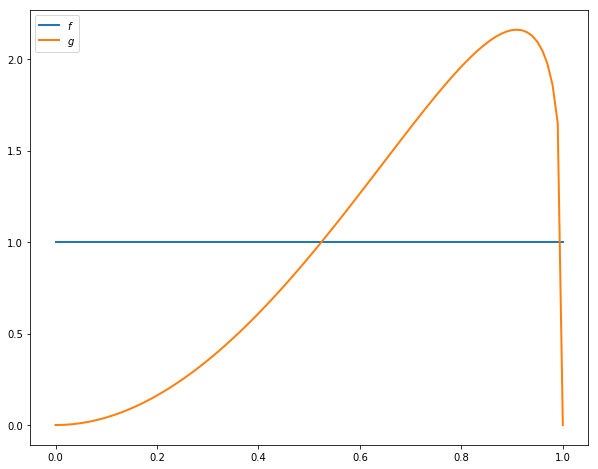

In [23]:
# Parameterization: define the distributions f and g by beta distribution.
def beta_function_factory(a, b):
    @vectorize
    def p(x):   # ?
        r = gamma(a+b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)
    return p

# set the values of x, f and g
x_grid = np.linspace(0, 1, 100)
f = beta_function_factory(1, 1)
g = beta_function_factory(3, 1.2)

# label distributions f and g against x
fig, ax = plt.subplots(figsize=(10, 8)) # set the size of the figure
ax.plot(x_grid, f(x_grid), label='$f$', lw=2) # label f; lw=2 (What does it mean?)
ax.plot(x_grid, g(x_grid), label='$g$', lw=2) # label g; (same question as above)

# plot the distributions
ax.legend() # add legend
plt.show()  # plot the graph

## 2.4 Looking forward

### Question

What kind of optimal policy might result from [(8)](#) and the parameterization specified above?

### Answer

Intuitively, if we accept at $w_a$ and $w_a \leq w_b$, then we should also accept at $w_b$, given all other things, which suggests a policy of accepting whenever $w$ exceeds some threshold value $\bar w$ (reservation wage).

But $\bar w$ should be decreasing in current guess $\pi$ (?**Where do we infer this from? from the example in 2.3? How we get this example from?**)because:

1. $f$ is a less attractive offer distribution than $g$;
2. Larger $\pi$ means more weight on $f$ and less on $g$.

Thus (Assume these above are true), larger $\pi$ depresses the worker's assessment of her future prospects,  and relatively low current offers become more attractive.

### Summary

We conjecture that the optimal policy is of the form
$$
\mathbb 1 \{ w \geq \bar w (\pi) \} \tag{10}
$$
for some decreasing function $\bar w$.

# 3 Take 1: solution by value function iteration (VFI)

Firstly, we use the class 'SearchProblem' to store (1) parameters of the "offer distribution unknown" model and (2) methods needed to compute optimal actions.

In [24]:
class SearchProblem:
    # '_init_': a reserved method in python classes, a constructor in ojbect oriented terminology.
    # it is called when an object is created from a class and it allows the class to initialze the attributes of the class
    def __init__(self,      
              β = 0.95,
              c = 0.3,
              F_a = 1, 
              F_b = 1,
               G_a = 3,
               G_b = 1.2,
               w_max = 1,
               w_grid_size = 100,
               π_grid_size = 100,
               mc_size = 500):
        
        # use self. to store values
        self.β, self.c, self.w_max = β, c, w_max # parameters in function
        
        self.f = beta_function_factory(F_a, F_b) # put parameters into beta_function_factory
        self.g = beta_function_factory(G_a, G_b) # similar as above
        
        self.π_min, self.π_max = 1e-3, 1-1e-3 # avoid instability?
        self.w_grid = np.linspace(0, w_max, w_grid_size) # generate a sequence for w_grid
        self.π_grid = np.linspace(self.π_min, self.π_max, π_grid_size) # similar as above
        
        self.mc_size = mc_size 
        
        self.w_f = np.random.beta(F_a, F_b, mc_size) # draw samples from a Beta distribution with parameters, a, b.
        self.w_g = np.random.beta(G_a, G_b, mc_size)

Then, the following function takes an instance of this class and returns jitted versions (?) of the Bellman operator $T$, and a function $get\_greedy()$ to compute the approximate optimal policy from a guess $v$ of the value function.

In [25]:
def operator_factory(sp, parallel_flag=True):  # ? Why & What is 'flag=True'?
    f, g = sp.f, sp.g                         # ?'sp.'????????? SearchProblem?? (The answer is yes!)
    w_f, w_g = sp.w_f, sp.w_g               
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid
    
    @njit
    def ϰ(w, π):       # calculate π_new using w and π as ϰ (w, π)
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)
        return π_new
    
    # jit version of Bellman operator
    @njit(parallel=parallel_flag) # what does 'parallel=parallel_flag' mean?e
    def T(v):
        # define a lambda expression that takes two arguments and returns mlinterp
        v_func = lambda x, y: mlinterp((w_grid, π_grid), v, (x, y))
        v_new = np.empty_like(v)
        
        # note: there are 3 loops; how to understand them? i, j, m
        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]
                
                v_1 = w / (1 - β)
                
                integral_f, integral_g = 0.0, 0.0
                # use v_func defined above to calculate integral_f & _g
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], ϰ(w_f[m], π))
                    integral_g += v_func(w_g[m], ϰ(w_g[m], π))
                integral = (π * integral_f + (1- π) * integral_g ) / mc_size
                v_2 = c + β * integral
                v_new[i, j] = max(v_1, v_2)
                
        return v_new
    
    # define 'get_ready' to compute optimal actions taking v as the value function
    # Q: 'get_greedy' almost the same as 'T(v)' except for the final return value,
    # Q': why we need both of them?
    @njit(parallel=parallel_flag)
    def get_greedy(v):
        v_func = lambda x, y: mlinterp((w_grid, π_grid), v, (x, y))
        σ = np.empty_like(v)
        
        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]
                
                v_1 = w / (1 - β)
                
                integral_f, integral_g = 0.0, 0.0
                # use v_func defined above to calculate integral_f & _g
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], ϰ(w_f[m], π))
                    integral_g += v_func(w_g[m], ϰ(w_g[m], π))
                integral = (π * integral_f + (1- π) * integral_g ) / mc_size
                v_2 = c + β * integral
                σ[i, j] = v_1 > v_2 # ?? evaluate to 1 or 0: if true, then 1; if false, then 0.
                
        return σ
    
    return T, get_greedy
        

Although a detailed discussion of the code is omitted in the lecture, I will discuss it.

To solve the model, we can use a function that iterates using $T$ to find a fixed point.

In [26]:
def solve_model(sp,               #sp is an instance of SearchProblem
               use_parallel=True, #?
               tol=1e-4,
               max_iter = 1000,
               verbose=True,      # verbose
               print_skip=5):
    
    T, _ = operator_factory(sp, use_parallel)
    
    # set basic parameters for the loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid) # len()
    
    # Initialize v; np.zeros((), dtype): return a new array of given shape () and type, filled with zeros
    v = np.zeros((m, n)) + sp.c / (1 - sp.β)  # np.zeros() 
    
    
    
    # 3 cases
    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:  # verbose: produce lots of logging output.
            print(f"Error at iteration {i} is {error}.")
        v = v_new
    
    if i == max_iter:
        print("Failed to converge!")
        
    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return v_new
    
    

### Remark:
verbose: produce lots of logging outputs.

np.zeros(): return a new array of given shape and type, filled with zeros.

Solutions computed from value function iteration (?).

Error at iteration 5 is 0.5989822681253631.
Error at iteration 10 is 0.10539530055685908.
Error at iteration 15 is 0.023490096644941616.
Error at iteration 20 is 0.005493155806910011.
Error at iteration 25 is 0.0013020433069570458.
Error at iteration 30 is 0.0003048905163325344.

Converged in 34 iterations.


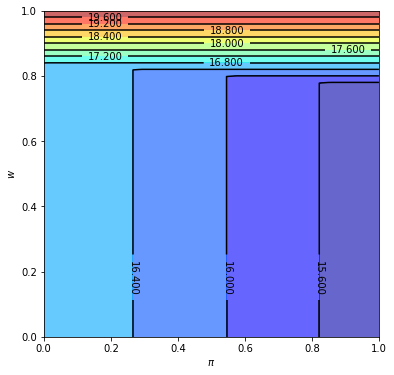

In [27]:
# use one class and one function defined before: SearchProblem and solve_model
sp = SearchProblem()

v_star = solve_model(sp)

fig, ax = plt.subplots(figsize=(6,6)) # plt.subplots? See above

# ax.contourf ?
ax.contourf(sp.π_grid, sp.w_grid, v_star, 12, alpha= 0.6, cmap=cm.jet)

# ax.contour ? What is the difference? Q: they are the same to some extents.
cs = ax.contour(sp.π_grid, sp.w_grid, v_star, 12, colors="black")

# ax.clablel ? See above
ax.clabel(cs, inline=1, fontsize=10)

# ax.set ??? See above
ax.set(xlabel='$\pi$', ylabel='$w$')

plt.show()

Attribute error (?):
Some mistakes in typing codes.

### Remark
[(plt.subplots())](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html):
create a figure and a set of subplots.

[(contour and contourf)](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.contourf.html):
draw contour lines and filled contours, respectively.
Except as noted, function signatures and return values are the same for both versions.

#### Note
1. contourf differs from the MATLAB version in that it does not draw the polygon edges. To draw edges, add line contours with calls to contour.

2. contourf fills intervals that are closed at the top.

[(ax.clabel())](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.clabel.html):
adds labels to line contours in cs, where cs is ContourSet object returned by contour()

[(ax.set())](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set.html):
sets axes' labels?





Plot the optimal policy.

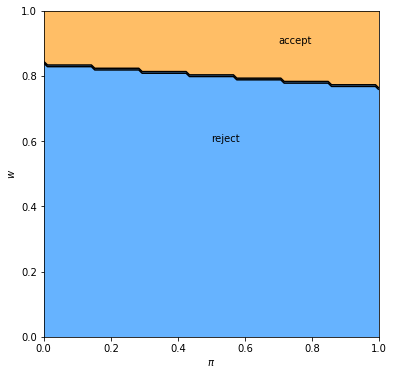

In [28]:
# Use two defined functions: operator_factory and get_greedy

T, get_greedy = operator_factory(sp)
σ_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize = (6, 6))
ax.contourf(sp.π_grid, sp.w_grid, σ_star, 1, alpha=0.6, cmap=cm.jet)
ax.contour(sp.π_grid, sp.w_grid, σ_star, 1, colors="black")
ax.set(xlabel='$\pi$', ylabel = '$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')

plt.show()

The results fit well with our intuition from the section 'Looking forward'.
1. The black line in the figure above corresponds to the function $\bar w (\pi) $ introduced there;
2. It is decreasing as expected.


# 4 Take 2: A much better method (Fixed-Point Approach)

## 4.1 Ideas behind

We can use iteration with an operator that has the same contraction rate (**? By definition of contractive mapping?**) as the Bellman operator (**?**), but 

1. one dimensional rather than two dimensional;
2. no maximization step.

As consequence (**? how to be this step**), the algorithm is orders of magnitude faster than VFI.

### Remark

Idea behind is just to solve the reservation wage function from the Bellman equation by using method in Functional Analysis.

## 4.2 Another functional equation

Since when $w = \bar w ( \pi)$, the worker is indifferent between accepting and rejecting, the two choices on the right-hand side of [(8)](#) have equal value:
$$
\frac{\bar w ( \pi)}{1- \beta} = c + \beta \int v(w ', \pi')q_{\pi}(w ')dw' \tag{11}
$$
 By [(8)](#) and [(11)](#), we have
$$
v(w, \pi) = \max \{ \frac{w}{1- \beta},  \frac{\bar w ( \pi)}{1- \beta} \} \tag{12}
$$
Plug [(12)](#) into [(11)](#), we have
$$
\frac{\bar w ( \pi)}{1- \beta} = c + \beta \int  \max \{ \frac{w'}{1- \beta},  \frac{\bar w ( \pi')}{1- \beta} \} q_{\pi}(w ')dw' \tag{13}
$$
Multiplying both sides of [(13)](#) by $1- \beta$, we obtain
$$
\bar w ( \pi) = (1- \beta) c + \beta (1- \beta) \int  \max \{ \frac{w'}{1- \beta},  \frac{\bar w ( \pi')}{1- \beta} \} q_{\pi}(w ')dw' \tag{14}
$$
 Since $(1- \beta)$ is a constant to the integral in the RHS of [(14)](#), we can put it inside the integral and hence the maximal function
$$
\bar w ( \pi) = (1- \beta) c + \beta  \int  \max \{ w',  \bar w ( \pi') \} q_{\pi}(w ')dw' \tag{15}
$$
Since $\pi' = \kappa (w', \pi)$, the $\bar w ( \pi')$ in the [(15)](#) can be rewritten as a composite function
$$
\bar w ( \pi') = \bar w \circ \kappa (w', \pi) \tag{16}
$$
Plug [(17)](#) into [(18)](#), we obtain
$$
\bar w ( \pi) = (1- \beta) c + \beta  \int  \max \{ w',  \bar w \circ \kappa (w', \pi) \} q_{\pi}(w ')dw' \tag{19}
$$
[(17)](#) can be interpreted as a functional equation (called **the reservation wage functional equation (RWFE)**), where $\bar w$ is the unknown function (also the solution to the RWFE, the object that we wish to compute).

## 4.3 Solving the RWFE

To solve the RWFE, we should first show that its solution is the fixed point of a contraction mapping. 

Let

1. $b[0,1]$ be the bounded real-valued functions on $[0,1]$;
2. $\| \omega \|= \sup_{x \in [0,1]} |w(x)|$.

Recall the definition of contraction mapping from the appendix of $4$ additional proofs:

### Def. (Contraction mapping)

The function $f$ is called a **contraction mapping** if, for some $0 \leq \alpha <1$, $f: X \to X$ satisfies:
$$
d(f(x), f(x')) \leq \alpha d(x, x') \ for \ all \ x,x' \in X \tag{20}
$$

### Define a function $Q$ from [(17)](#) and prove that it is a contraction mapping

Consider the operator $Q$ mapping $\omega \in b[0,1]$ into $Q \omega \in b[0,1]$ via
$$
(Q \omega) (\pi) = (1- \beta) c + \beta \int \max \{ w', \omega \circ \kappa (w', \pi) \} q_{\pi} (w') dw' \tag{21}
$$
Comparing [(17)](#) and [(18)](#), we know that the set of fixed points of $Q$ exactly coincides with the set of solutions to the RWFE (**then we can do the proof by using the Banach Fixed-Point Theorem, there should be more reasoning**), that is,
$$
Q\bar \omega = \bar \omega \iff \bar w \ solves\ (16) \tag{22}
$$
For any $ \omega, \omega' \in b[0,1]$, by basic algebra and the triangle inequality for integrals (**? What is that?**), we have (**there should be more reasoning**)
$$
| (Q \omega) (\pi) - (Q \omega') (\pi) | \leq \beta \int |\max \{ w', \omega \circ \kappa (w', \pi) \} -\max \{ w', \omega' \circ \kappa (w', \pi) \} | q_{\pi} (w') dw' \tag{23}
$$
Easy to check that for real numbers $a, b,c$ (**? To be checked! Work case by case**), we always have
$$
| \max \{ a,b \} - \max \{ b,c \} | \leq |b-c| \tag{24}
$$
By [(22)](#), the inequality [(21)](#) becomes
$$
| (Q \omega) (\pi) - (Q \omega') (\pi) | \leq \beta \int |\max \{ w', \omega \circ \kappa (w', \pi) \} -\max \{ w', \omega' \circ \kappa (w', \pi) \} | q_{\pi} (w') dw'\\
\leq \beta \int | \omega \circ \kappa (w', \pi)  - \omega' \circ \kappa (w', \pi) \} | q_{\pi} (w') dw' \tag{25}
$$
And because of **what?**, [(24)](#) also becomes
$$
| (Q \omega) (\pi) - (Q \omega') (\pi) | \leq \beta \int |\max \{ w', \omega \circ \kappa (w', \pi) \} -\max \{ w', \omega' \circ \kappa (w', \pi) \} | q_{\pi} (w') dw'\\
\leq \beta \int | \omega \circ \kappa (w', \pi)  - \omega' \circ \kappa (w', \pi) \} | q_{\pi} (w') dw' \\
\leq \beta \| \omega - \omega' \| \tag{26}
$$
Taking the supremum over $\pi$ yields
$$
\| Q \omega - Q \omega' \| \leq \beta \| \omega - \omega'  \| \tag{27}
$$
that is, $Q$ is a contraction of modulus $\beta$ on the complete metric space $(b [0,1], \| \cdot \|)$.

Recall appendix of $4$ additional proofs.

### Banach's Fixed-Point Theorem

If $f: X \to X$ is contraction mapping defined on a complete metric space $(X,d)$, then .there exists an unique fixed point of $f$.

### Summary

By Banach's Fixed-Point theorem, we can draw two conclusions:

1. A unique solution $\bar w$ to the RWFE exists in $b[0,1]$.
2. $Q^k \omega \to \bar w$ uniformly as $k \to \infty$, for any $\omega \in b[0,1]$ (**How to reach this conclusion?**)


## 4.4 Implementation


The following function takes an instance of $SearchProblem$ and returns the operator $Q$.

In [29]:
def Q_factory(sp, parallel_flag=True):
    # use stored values
    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size #?? mc.size
    w_grid, π_grid = sp.w_grid, sp.π_grid
    
    @njit
    def ϰ(w, π):
        pf, pg = π * f(w), (1- π) * g(w)
        π_new = pf / (pf + pg)
        return π_new
    
    @njit(parallel=parallel_flag)
    def Q(ω):
        ω_func = lambda p: interp(π_grid, ω, p)
        ω_new = np.empty_like(ω)
        
        for i in prange(len(π_grid)):
            π = π_grid[i]
            integral_f, integral_g = 0.0, 0.0
            
            for m in prange(mc_size):
                integral_f += max(w_f[m], ω_func(ϰ(w_f[m], π)))
                integral_g += max(w_g[m], ω_func(ϰ(w_g[m], π)))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size
            ω_new[i] = (1- β) * c + β * integral
            
        return ω_new
    return Q

    

# 5 Exercise 1

1. Use the default parameters and $Q\_factory$ to compute an optimal policy (That is, to compute an approximation to $\bar w$).
2. Experiment with different parameters, and confirm that the change in the optimal policy coincides with our intuition.


## 5.1 Answer:

Similar to $solve\_model$ in take 1, we define a function $solve\_wbar$ to iterate $Q$ to find the fixed point.

In [30]:
def solve_wbar(sp,               #? sp is an instance of SearchProblem
               use_parallel=True, #?
               tol=1e-4,
               max_iter = 1000,
               verbose=True,      # verbose ?
               print_skip=5):
    
    Q = Q_factory(sp, use_parallel)
    
    # set basic parameters for the loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid) # len()
    
    # Initialize v
    w = np.ones_like(sp.π_grid)  #
    
    # 3 cases
    while i < max_iter and error > tol:
        w_new = Q(w)
        error = np.max(np.abs(w - w_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        w = w_new
    
    if i == max_iter:
        print("Failed to converge!")
        
    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return w_new
    

We can compute $w\_bar$ using the function above, and plot it as a figure, which also agrees with our intuition about the relationship between $\bar w$ and $\pi$.

Error at iteration 5 is 0.022337465374145937.
Error at iteration 10 is 0.007438933945799309.
Error at iteration 15 is 0.0018739745054835444.
Error at iteration 20 is 0.0004373966490129888.
Error at iteration 25 is 0.00010134507372216994.

Converged in 26 iterations.


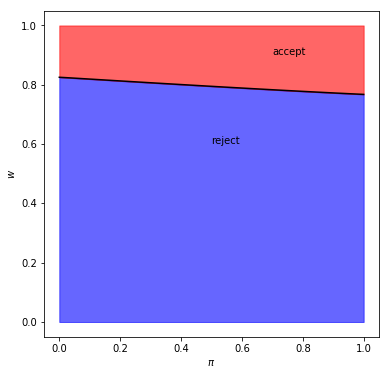

In [31]:
sp = SearchProblem()
w_bar = solve_wbar(sp)

fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(sp.π_grid, w_bar, color='k')
ax.fill_between(sp.π_grid, 0, w_bar, 1, alpha=0.6, color='blue')
ax.fill_between(sp.π_grid, w_bar, sp.w_max, color='red', alpha=0.6)

ax.set(xlabel='$\pi$', ylabel = '$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')

plt.show()

Next, we try to change the underlying distribution to significant worse at a point in the simulation, to see the effect of a change on unemployment rate.

We will see that it takes a while for agents to learn this, and in the meantime, they are too optimistic and turn down too many jobs.


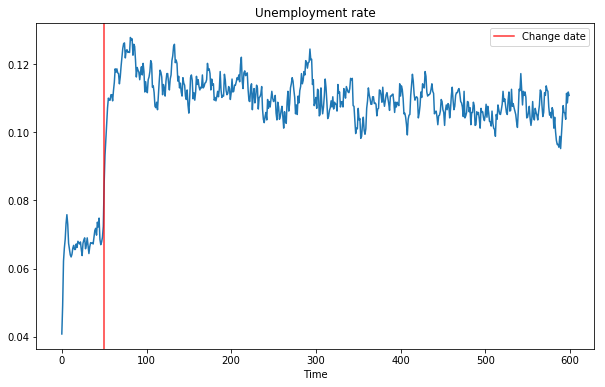

In [32]:
F_a, F_b, G_a, G_b = 1, 1, 3, 1.2

sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b)
f, g = sp.f, sp.g

# solve for reservation wage
w_bar = solve_wbar(sp, verbose=False)

# interpolate reservation wage function
π_grid = sp.π_grid
w_func = njit(lambda x: interp(π_grid, w_bar, x)) # How to understand the function here?

@njit
def update(a, b, e, π):  # π is the prior probability on f, but how to understand e????? (error?)
    
    if e == False:
        w = np.random.beta(a, b) # set the w as the beta distribution with parameters a, b, which can be changed.
        if w >= w_func(π):
            e = True
        else:
            π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))   # Why π looks like this? A: Just divided both numerator and denominator by π * f(w) 
        
    return e, π
                     

# So e should be the employment rate, we define this function to simulate it.
@njit
def simulate_path(F_a = F_a,
                 F_b = F_b,
                 G_a = G_a,
                 G_b = G_b,
                 N=5000,
                 T= 600,
                 d=200,
                 s=0.025):
    # So it seems that e and π are both related to n and t, so how to understand n and t here?                 
    e = np.ones((N, T+1))
    π = np.ones((N, T+1)) * 1e-3
                     
    a, b = G_a, G_b
    
    for t in range(T+1):
        if t == d:
            a, b = F_a, F_b
                     
        for n in range(N):
            if e[n, t] == 1:
                p = np.random.uniform(0,1)
                if p <= s:
                     e[n, t] = 0
                     
            new_e, new_π = update(a, b, e[n, t], π[n, t])
            e[n, t+1] = new_e
            π[n, t+1] = new_π
                     
    return e[:, 1:]

# calculate the unemployment rate when the change happens on the day d = 50
d = 50
unemployment_rate = 1 - simulate_path(d=d).mean(axis=0)
                     
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemployment_rate)
ax.axvline(d, color='r', alpha=0.8, label='Change date') # ax.axvline(): add a vertical line across the axes;

# label the figure, add the legend and plot the figure
ax.set_xlabel('Time')
ax.set_title('Unemployment rate')
ax.legend()
plt.show()
                    

### Remark

1. From the time 0 to the time (d-t), the unemployment rate rises from 0 to the stationary level immediately;

2. Around the changing day d, the unemployment rate change immediately from one stationary level to another.

3. After the changing day d, the unemployment rate tends to go up immediately and then go down fluctuately.

4. After reaching its stationary level, the unemployment rate tend to keep stable again.

5. This is a negative shock (negative belief about future wage level).